# Introduction to JAX

Written by Ben Moseley


## What is JAX?

<img src="what-is-jax.png" width=80%>

In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=2'
import jax
import matplotlib.pyplot as plt

# Arrays with JAX NumPy

In [2]:
import jax.numpy as jnp

x = jnp.array([[0., 2., 4.]])
print(x, x.shape)
print(x @ x.T)
print(x * x.T)

[[0. 2. 4.]] (1, 3)
[[20.]]
[[ 0.  0.  0.]
 [ 0.  4.  8.]
 [ 0.  8. 16.]]


# Autodifferentiation with JAX

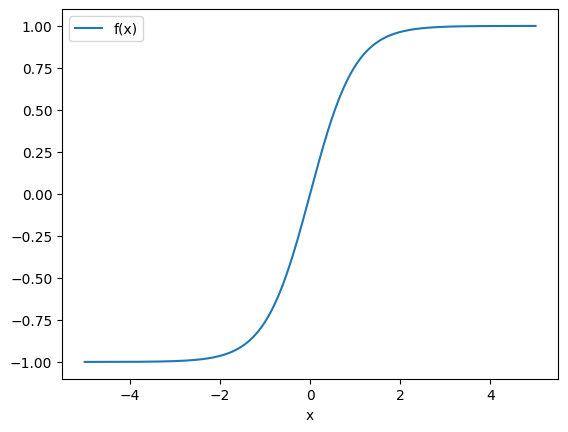

In [3]:
def fn(x):
    return jnp.tanh(x)

x = jnp.linspace(-5,5,500)

plt.plot(x, fn(x), label="f(x)")
plt.legend()
plt.xlabel("x")
plt.show()

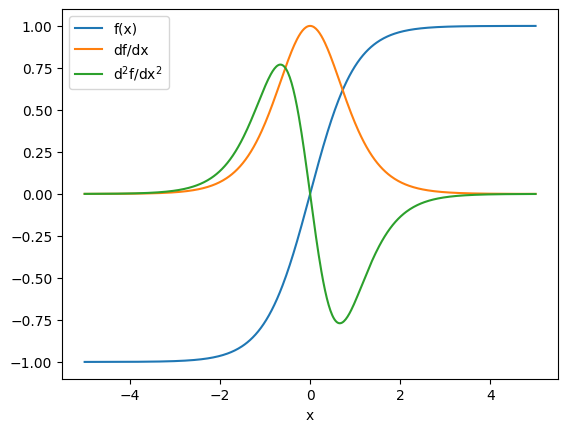

In [4]:
# gradient
dfdx_fn = jax.grad(fn)# assumes f is a scalar-output function
d2fdx2_fn = jax.grad(dfdx_fn)

plt.plot(x, fn(x), label="f(x)")
plt.plot(x, [dfdx_fn(x_) for x_ in x], label="df/dx")
plt.plot(x, [d2fdx2_fn(x_) for x_ in x], label="d$^2$f/dx$^2$")
plt.legend()
plt.xlabel("x")
plt.show()

In [5]:
print(jax.make_jaxpr(fn)(x))# JAX transforms programs using a simple intermediate language call jaxpr

{ lambda ; a:f32[500]. let b:f32[500] = tanh a in (b,) }


In [6]:
# Jacobian
jacobian_fn = jax.jacfwd(fn)
j = jacobian_fn(x)
print(j)
print(j.shape)

[[0.00018167 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00018894 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00019669 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00019669 0.         0.        ]
 [0.         0.         0.         ... 0.         0.00018894 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00018167]]
(500, 500)


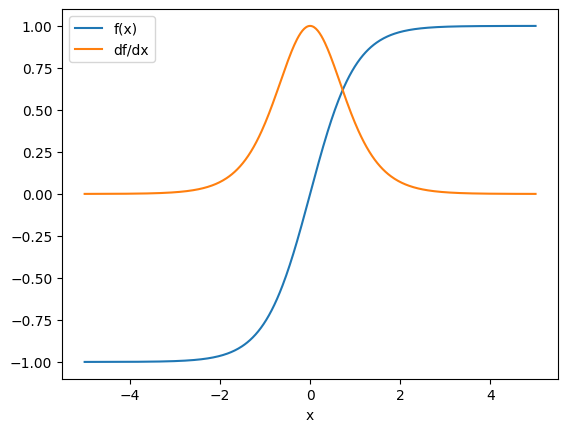

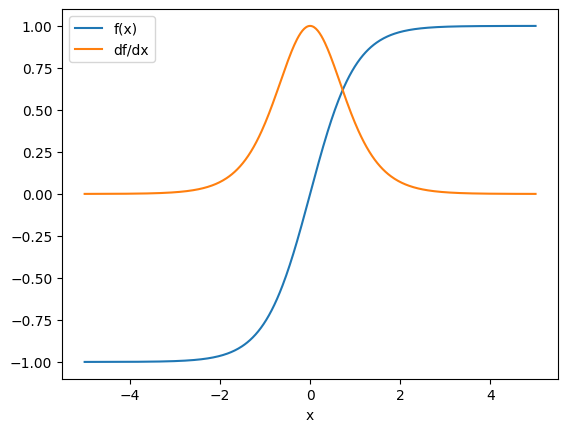

In [7]:
# vector-Jacobian product
f, vjp_fn = jax.vjp(fn, x)
dfdx, = vjp_fn(jnp.ones_like(x))

plt.plot(x, f, label="f(x)")
plt.plot(x, dfdx, label="df/dx")
plt.legend()
plt.xlabel("x")
plt.show()

# Jacobian-vector product
f, dfdx = jax.jvp(fn, (x,), (jnp.ones_like(x),))

plt.plot(x, f, label="f(x)")
plt.plot(x, dfdx, label="df/dx")
plt.legend()
plt.xlabel("x")
plt.show()

# Vectorisation with JAX

In [8]:
def forward_fn(w, b, x):
    x = w @ x + b
    x = jnp.tanh(x)
    return x

key = jax.random.key(seed=0)
key1, key2, key3 = jax.random.split(key, 3)
x = jax.random.normal(key1, (3,))
w = jax.random.normal(key2, (10,3))
b = jax.random.normal(key3, (10,))
y = forward_fn(w, b, x)
print(x.shape)
print(y.shape)

(3,)
(10,)


In [9]:
forward_batch_fn = jax.vmap(forward_fn, in_axes=(None, None, 0))# computes batch using vectorisation

x_batch = jax.random.normal(key, (1000,3))
y_batch = forward_batch_fn(w, b, x_batch)
print(x_batch.shape)
print(y_batch.shape)

(1000, 3)
(1000, 10)


# Just-in-time compilation with JAX

In [10]:
def fn(x):
    return x + x*x + x*x*x

jit_fn = jax.jit(fn)

x = jax.random.normal(key, (1000,1000))
%timeit fn(x).block_until_ready()
%timeit jit_fn(x).block_until_ready()

887 µs ± 21 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
121 µs ± 369 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Putting it all together: linear regression

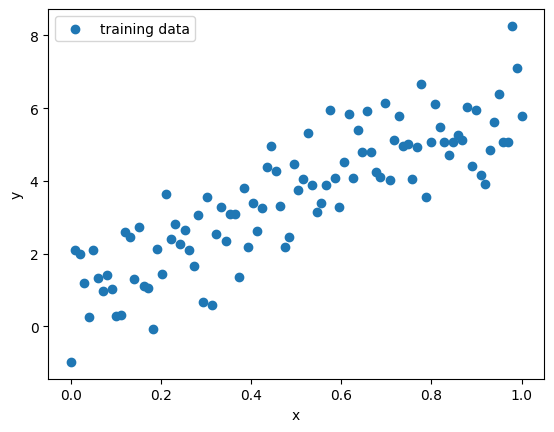

In [11]:
x_batch = jnp.linspace(0, 1, 100).reshape((100,1))
y_label_batch = 5*x_batch + 1 + jax.random.normal(key, (100,1))

plt.scatter(x_batch, y_label_batch, label="training data")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()

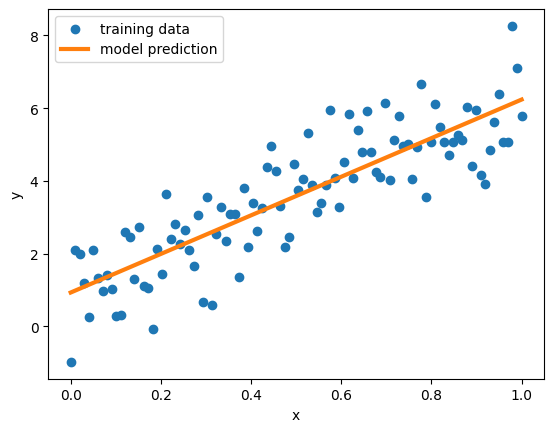

(Array([[5.308165]], dtype=float32), Array([0.9280475], dtype=float32, weak_type=True))


In [12]:
def init():
    "Returns initial model parameters"
    w = jnp.array(0.).reshape((1,1))
    b = jnp.array(0.).reshape((1,))
    theta = (w,b)
    return theta

def forward(theta, x):
    "Returns model prediction, for a single example input"
    w, b = theta
    x = w @ x + b
    return x

forward_batch = jax.vmap(forward, in_axes=(None, 0))# batched version of forward

def loss(theta, x_batch, y_label_batch):
    "Computes mean squared error between model prediction and training data"
    y_batch = forward_batch(theta, x_batch)
    return jnp.mean((y_batch-y_label_batch)**2)

grad = jax.value_and_grad(loss, argnums=0)# gradient of loss wrt model parameters

def step(lrate, theta, x_batch, y_label_batch):
    "Performs one gradient descent step on model parameters, given training data"
    lossval, dldt = grad(theta, x_batch, y_label_batch)
    theta = jax.tree_map(lambda t,dt: t-lrate*dt, theta, dldt)
    return theta, lossval

jit_step = jax.jit(step)# makes step go brr


# initialise model parameters
theta = init()

# run gradient descent
for i in range(1000):
    theta, lossval = jit_step(0.1, theta, x_batch, y_label_batch)

plt.scatter(x_batch, y_label_batch, label="training data")
plt.plot(x_batch, forward_batch(theta, x_batch), color="tab:orange", lw=3, label="model prediction")
plt.legend()
plt.xlabel("x"); plt.ylabel("y")
plt.show()
print(theta)

# Extra: multi-device parallelisation with JAX

In [13]:
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

print(jax.devices())

x = jax.random.normal(key, (8192, 8192))

sharding = PositionalSharding(jax.devices()).reshape(2,1)
x = jax.device_put(x, sharding)
jax.debug.visualize_array_sharding(x)# shards array across first dimension

y = x**2
jax.debug.visualize_array_sharding(y)# "computation follows sharding" paradigm

y = jnp.mean(x**2, axis=0, keepdims=True)# compiler also inserts communication as necessary!
jax.debug.visualize_array_sharding(y)# result is replicated across devices

[CpuDevice(id=0), CpuDevice(id=1)]


                         
                         
          CPU 0          
                         
                         
                         
                         
                         
          CPU 1          
                         
                         
                         

                         
                         
          CPU 0          
                         
                         
                         
                         
                         
          CPU 1          
                         
                         
                         

                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                    CPU 0,1                                     
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                